# Evaluate retrained DNN

GAL and LAL have extended the dataset, which was used to retrain the DNN

## Setup

### Import

In [ ]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import copy
import math
import random
import time
import pickle

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
import torch

from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

os.chdir(os.path.dirname(os.getcwd()))
from Settings import Directory, Plotting_Parameters
from DataReader import DataReader
from DNN import DNN
from Plot_Functions import plot_MV_interaction
from Plot_Functions import find_similar_profiles

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [ ]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [ ]:
datareader = DataReader()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_filtered_converted.csv
Extended_Database_FilterOn.csv
Extended_Database_test.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD


In [ ]:
# Disable if plots should not be saved
plot_params.save_figures = True

### Load Data

In [4]:
df_full = datareader.load('Knee_Connection_Output_red.csv')

Knee_Connection_Output_red.csv: (714385, 53)


In [19]:
df_extension_01 = datareader.load('extended_profiles_iter_1.csv')

extended_profiles_iter_1.csv: (6000, 59)


In [21]:
df_extension_02 = datareader.load('extended_profiles_iterV2_1.csv')

extended_profiles_iterV2_1.csv: (6000, 60)


In [ ]:
df_LAL = pd.concat([df_full, df_extension_01, df_extension_02], axis=0, ignore_index=True)

### Load Models

In [9]:
model_name = "DNN_Model_Full_V3"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model_org = torch.load(MODEL_SAVE_FILE)
df_org = df_full.loc[model_org.data['data_indeces']]

In [26]:
model_name = "DNN_Model_LAL_Retrain"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model_LAL = torch.load(MODEL_SAVE_FILE)

In [64]:
df_AL = datareader.load('Extended_Database_filtered_converted.csv')

Extended_Database_filtered_converted.csv: (726385, 62)


Load model finetuned during Active Learning:

In [29]:
model_AL = torch.load(os.path.join(directory.root,
                      "Saved Models",
                      "DNN_Model_AL_Finetuned_FilterOn",
                      "DNN_Model_AL_Finetuned_FilterOn.pth"))

Load model trained from initial dataset + added data in AL. The training parameters are the same as for the original model.

In [30]:
model_retrained = torch.load(os.path.join(directory.root,
                      "Saved Models",
                      "DNN_Model_LAL_Retrain",
                      "DNN_Model_LAL_Retrain.pth"))

Function to find computational issues:

In [34]:
def identify_computational_issue(df_group,threshold_x=0.2, threshold_y=0.2):
    if df_group.iloc[-1]['template'] != 'Corner.ideaCon':
        return False
    
    n_before = len(df_full)
    group = np.array(df_group.index)
    mask_before = np.where(np.array(group) < n_before)[0]
    mask_added = np.where(np.array(group) >= n_before)[0]

    M_Rd_calc = df_group['M_Rd'].values
    V_Rd_calc = df_group['V_Rd'].values

    base_profile = df_group.iloc[0].copy()
    M_Rd_pred, V_Rd_pred, _ = model_org.get_MV_interaction_prediction(base_profile,n_predictions=20)

    # Calculate distance to interaction curve
    interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
    added_resistances = np.array([M_Rd_calc[mask_added], V_Rd_calc[mask_added]]).T

    ids_on_y_axis = np.argmin(np.abs(added_resistances[:,0].reshape(-1,1)-interaction_curve[:,0]),axis=1)
    ids_on_x_axis = np.argmin(np.abs(added_resistances[:,1].reshape(-1,1)-interaction_curve[:,1]),axis=1)

    error_on_x = interaction_curve[:,0][ids_on_x_axis] - added_resistances[:,0].astype(float)
    error_on_y = interaction_curve[:,1][ids_on_y_axis] - added_resistances[:,1].astype(float)   

    rel_error_on_y = error_on_y / interaction_curve[:,1][ids_on_y_axis]
    rel_error_on_x = error_on_x / interaction_curve[:,0][ids_on_x_axis]

    if np.isnan(rel_error_on_x).any() or np.isinf(rel_error_on_x).any() or (rel_error_on_x < 0).any():
        return False
    if np.isnan(rel_error_on_y).any() or np.isinf(rel_error_on_y).any() or (rel_error_on_y < 0).any():
        return False
    
    if np.all(rel_error_on_y>threshold_y) and np.all(rel_error_on_x>threshold_x):
        print('Error on x:', rel_error_on_x)
        print('Error on y:', rel_error_on_y)
        return True
    
    return False

In [52]:
fixed_features = model_org.features.copy()
fixed_features.remove('M_contribution')
fixed_features.remove('V_contribution')

In [53]:
identical_groups = df_AL[fixed_features].groupby(list(df_AL[fixed_features].columns)).apply(lambda x: x.index.tolist()).tolist()

In [71]:
validmask = []
for i,group in enumerate(identical_groups):
    if np.max(group) >= len(df_full):
        if not identify_computational_issue(df_AL.loc[group]):
            validmask.append(np.array(group)[np.array(group)>=len(df_full)])
        

Error on x: [0.2015831 0.2015831 0.2015831]
Error on y: [1. 1. 1.]
Error on x: [0.28797384 0.26169614 0.21845312 0.27892993 0.26103055 0.25742283]
Error on y: [0.36798233 0.60310793 0.2238606  0.49604465 0.33804284 0.71196769]
Error on x: [0.21020263 0.20340491 0.21556288]
Error on y: [1.         0.6541515  0.80225736]
Error on x: [0.21535999 0.20341823 0.21865833]
Error on y: [1.         0.65326551 0.801796  ]
Error on x: [0.25052619 0.25052619 0.25052619 0.24648798 0.25089668 0.2431292 ]
Error on y: [1.         1.         1.         0.7263639  0.85112256 0.54728198]
Error on x: [0.28002241 0.24607579 0.28625343 0.26555062 0.262584   0.26989603]
Error on y: [0.48016212 0.51084306 0.40039232 0.43906296 0.51678845 0.35665828]
Error on x: [0.24078497 0.24601835 0.25372292 0.25741018 0.24035447 0.2659586 ]
Error on y: [0.69105398 0.74248573 0.5931893  0.6424506  0.7392685  0.61791906]
Error on x: [0.32593745 0.30052612 0.28878892]
Error on y: [0.24150126 0.31836411 0.5332323 ]
Error on x:

In [ ]:
validmask = np.concatenate(validmask)

In [80]:
df_AL_valid = pd.concat([df_org, df_AL.loc[validmask]])

In [84]:
df_AL_valid.reset_index(drop=True, inplace=True)

Get Metrics of the original, finetuned and retrained model.

In [87]:
ids_added = np.arange(len(df_full), len(df_AL_valid))
ids_before = np.array(list(df_full.index))
df_added = df_AL_valid.loc[ids_added].copy()

# Get Predictions before AL
y_truth = df_AL_valid['target'].values

# Get Predictions after AL
y_preds_before, _ = model_org.predict(df_AL_valid)
y_preds_finetune, _ = model_AL.predict(df_AL_valid)
y_preds_retrain, _ = model_retrained.predict(df_AL_valid)

y_preds_before = y_preds_before.numpy().flatten()
y_preds_finetune = y_preds_finetune.numpy().flatten()
y_preds_retrain = y_preds_retrain.numpy().flatten()

# Calculate relative error
error_before = np.abs((y_preds_before - y_truth) / (y_truth + 1e-8))
error_finetune = np.abs((y_preds_finetune - y_truth) / (y_truth + 1e-8))
error_retrain = np.abs((y_preds_retrain - y_truth) / (y_truth + 1e-8))

R2_before = 1 - np.sum((y_preds_before - y_truth)**2) / np.sum((y_truth - np.mean(y_truth))**2)
R2_finetune = 1 - np.sum((y_preds_finetune - y_truth)**2) / np.sum((y_truth - np.mean(y_truth))**2)
R2_retrain = 1 - np.sum((y_preds_retrain - y_truth)**2) / np.sum((y_truth - np.mean(y_truth))**2)

### Original, Finetuned, Retrained Model Accuracy

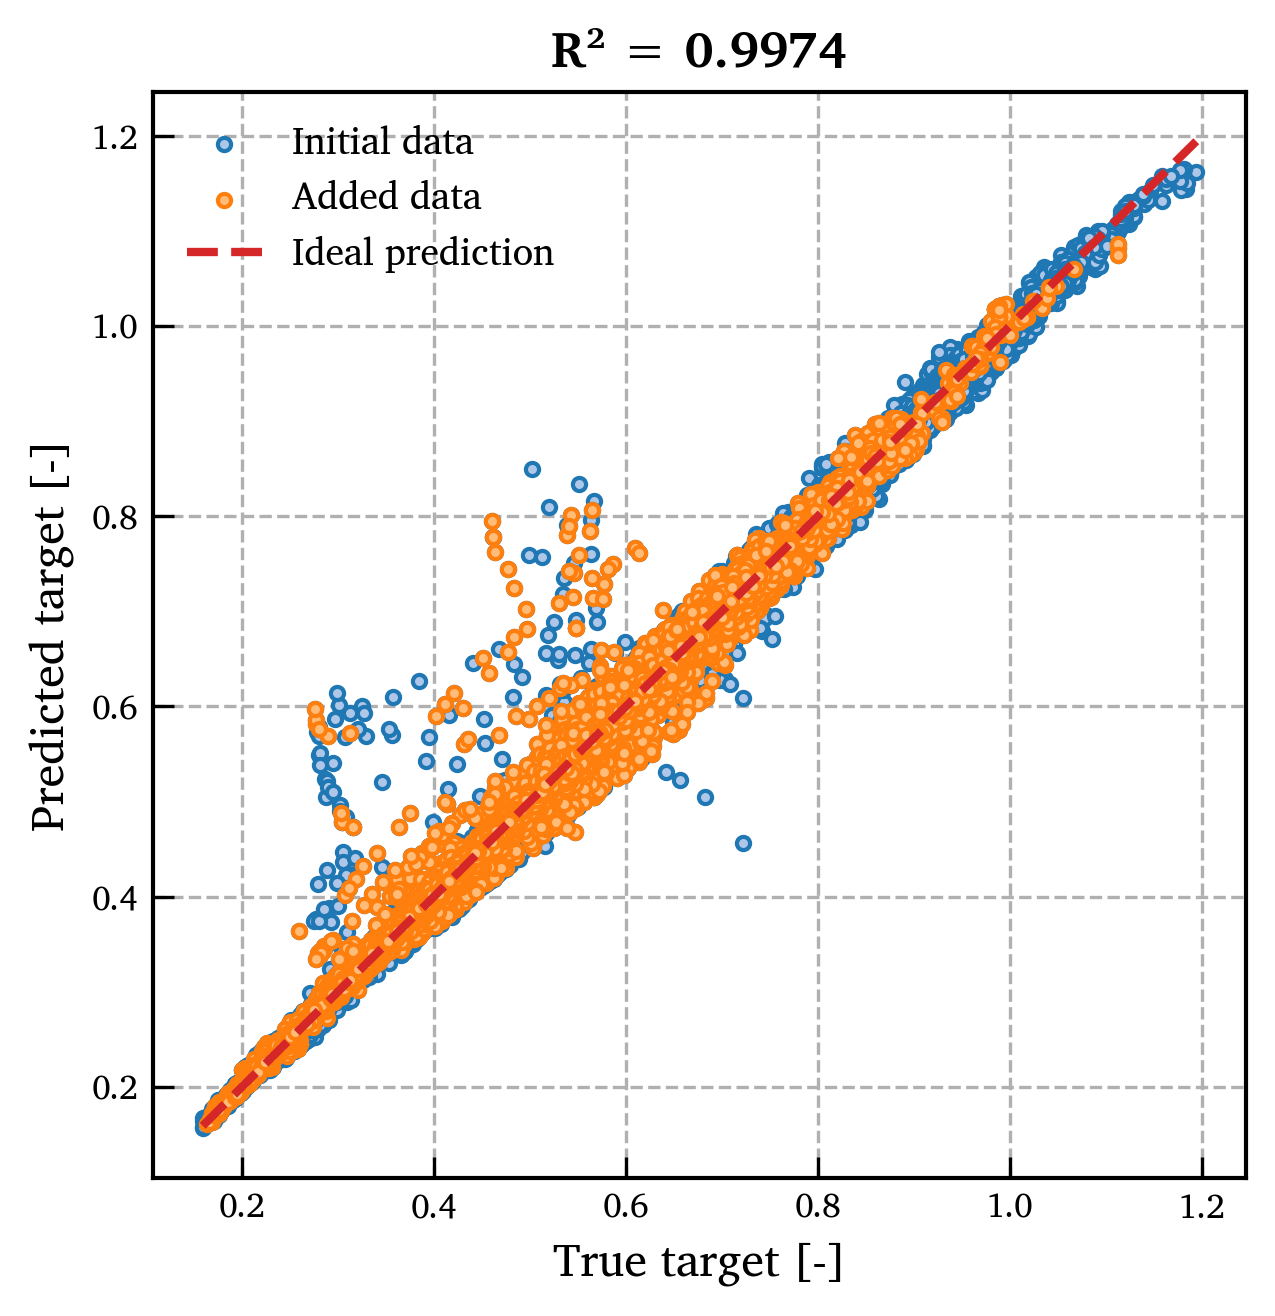

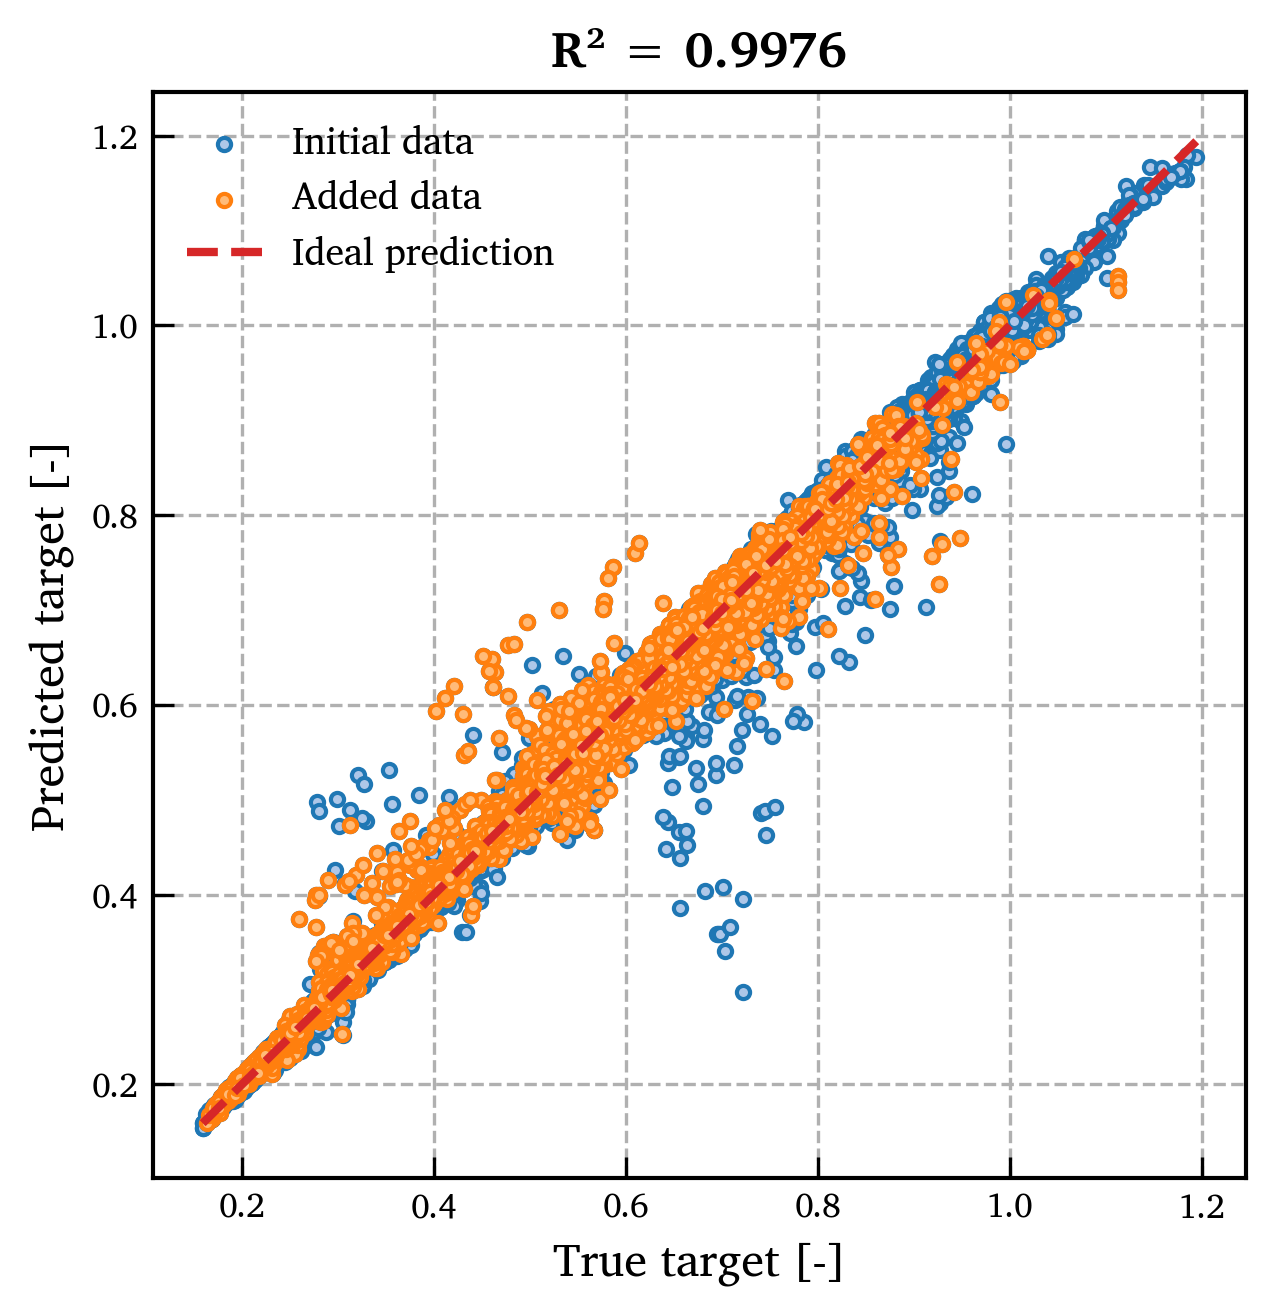

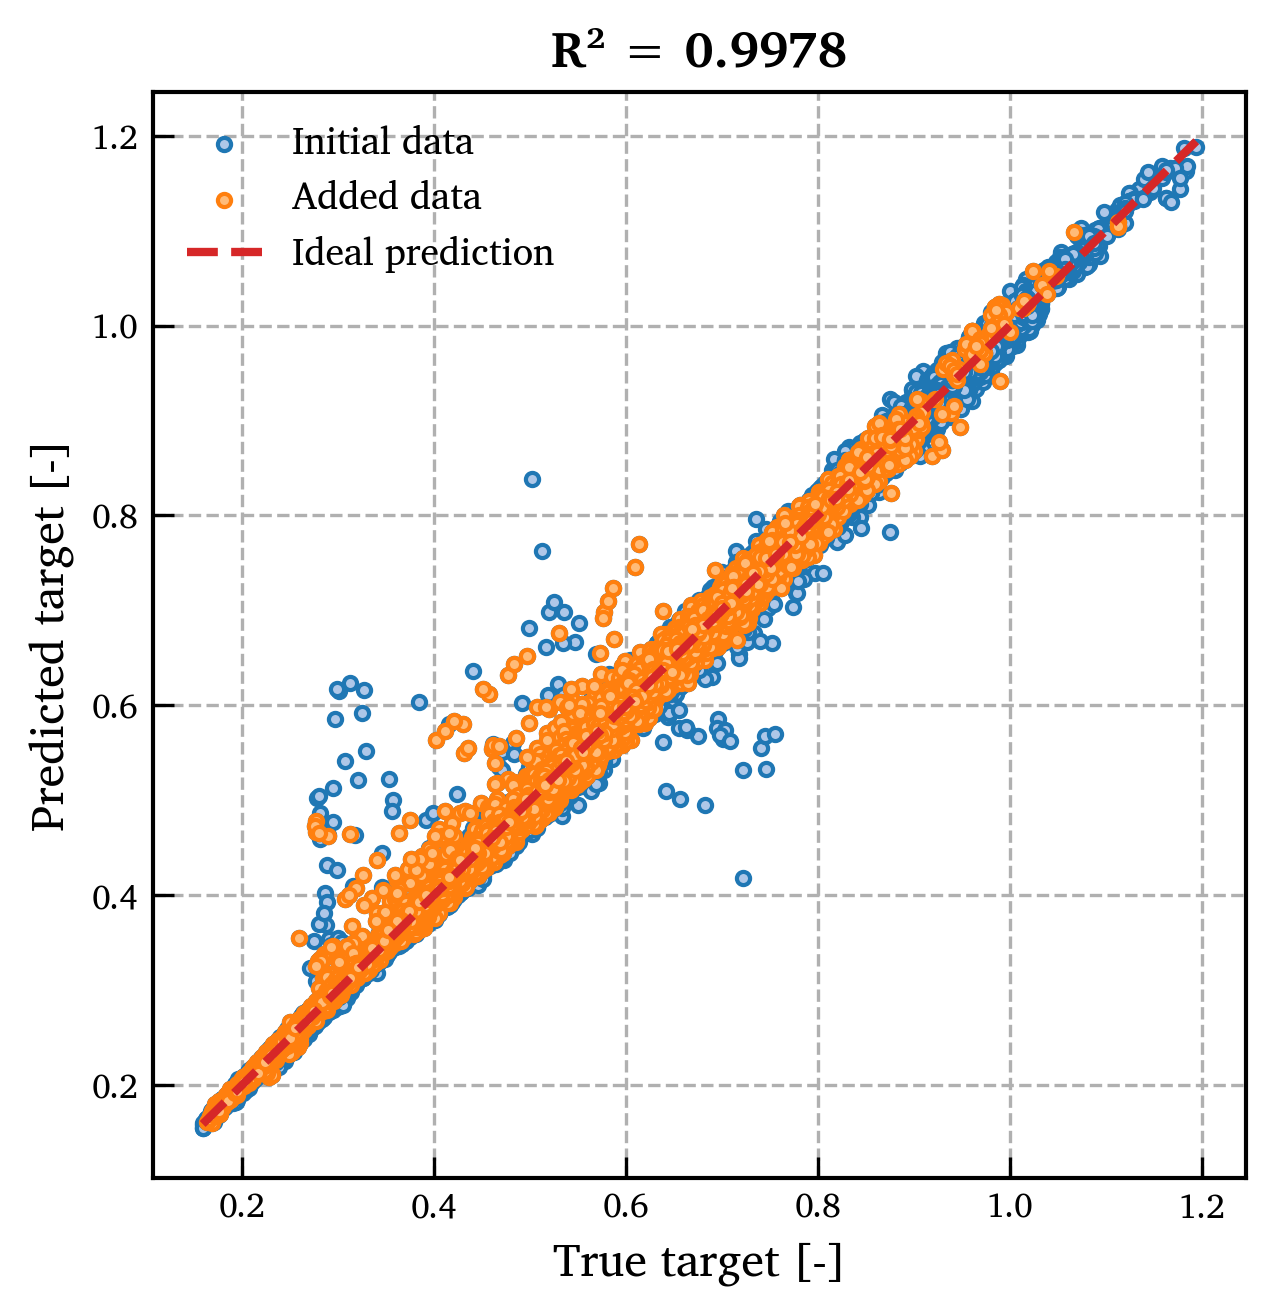

In [88]:
for i,y in enumerate([y_preds_before, y_preds_finetune, y_preds_retrain]):
   fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75,1.0))

   R2 = 1 - np.sum((y - y_truth)**2) / np.sum((y_truth - np.mean(y_truth))**2)

   ax.scatter(y_truth, y,
               label='Initial data', 
               facecolor=plot_params.morecolors[1],
               edgecolor=plot_params.morecolors[0],
               s=10,
               zorder=2
               )

   ax.scatter(y_truth[ids_added], y[ids_added],
               label='Added data',
               facecolor=plot_params.morecolors[3],
               edgecolor=plot_params.morecolors[2],
               s=10,
               zorder=2
               )

   ax.plot([y_truth.min(), y_truth.max()],
               [y_truth.min(), y_truth.max()], 
               color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal prediction',
               zorder=3)
   ax.set_title(f'R² = {R2:.4f}', fontsize=12, fontweight='bold')

   ax.grid(True, linestyle='--', zorder=0)
   ax.legend()

   ax.set_xlabel('True target [-]')
   ax.set_ylabel('Predicted target [-]')

   plt.show()

### Original, Retrained test data Evaluation

In [39]:
df_test = df_full.loc[model_org.data['test_data']].copy()

In [40]:
y_test = df_test['target'].values
y_preds_test, _ = model_org.predict(df_test)
y_preds_test = y_preds_test.numpy().flatten()
R2_test = 1 - np.sum((y_preds_test - y_test)**2) / np.sum((y_test - np.mean(y_test))**2)

y_preds_test_retrain, _ = model_retrained.predict(df_test)
y_preds_test_retrain = y_preds_test_retrain.numpy().flatten()
R2_test_retrain = 1 - np.sum((y_preds_test_retrain - y_test)**2) / np.sum((y_test - np.mean(y_test))**2)

error_test_before = np.abs((y_preds_test - y_test) / (y_test + 1e-8))
error_test_retrain = np.abs((y_preds_test_retrain - y_test) / (y_test + 1e-8))

#### Accuracy Comparison

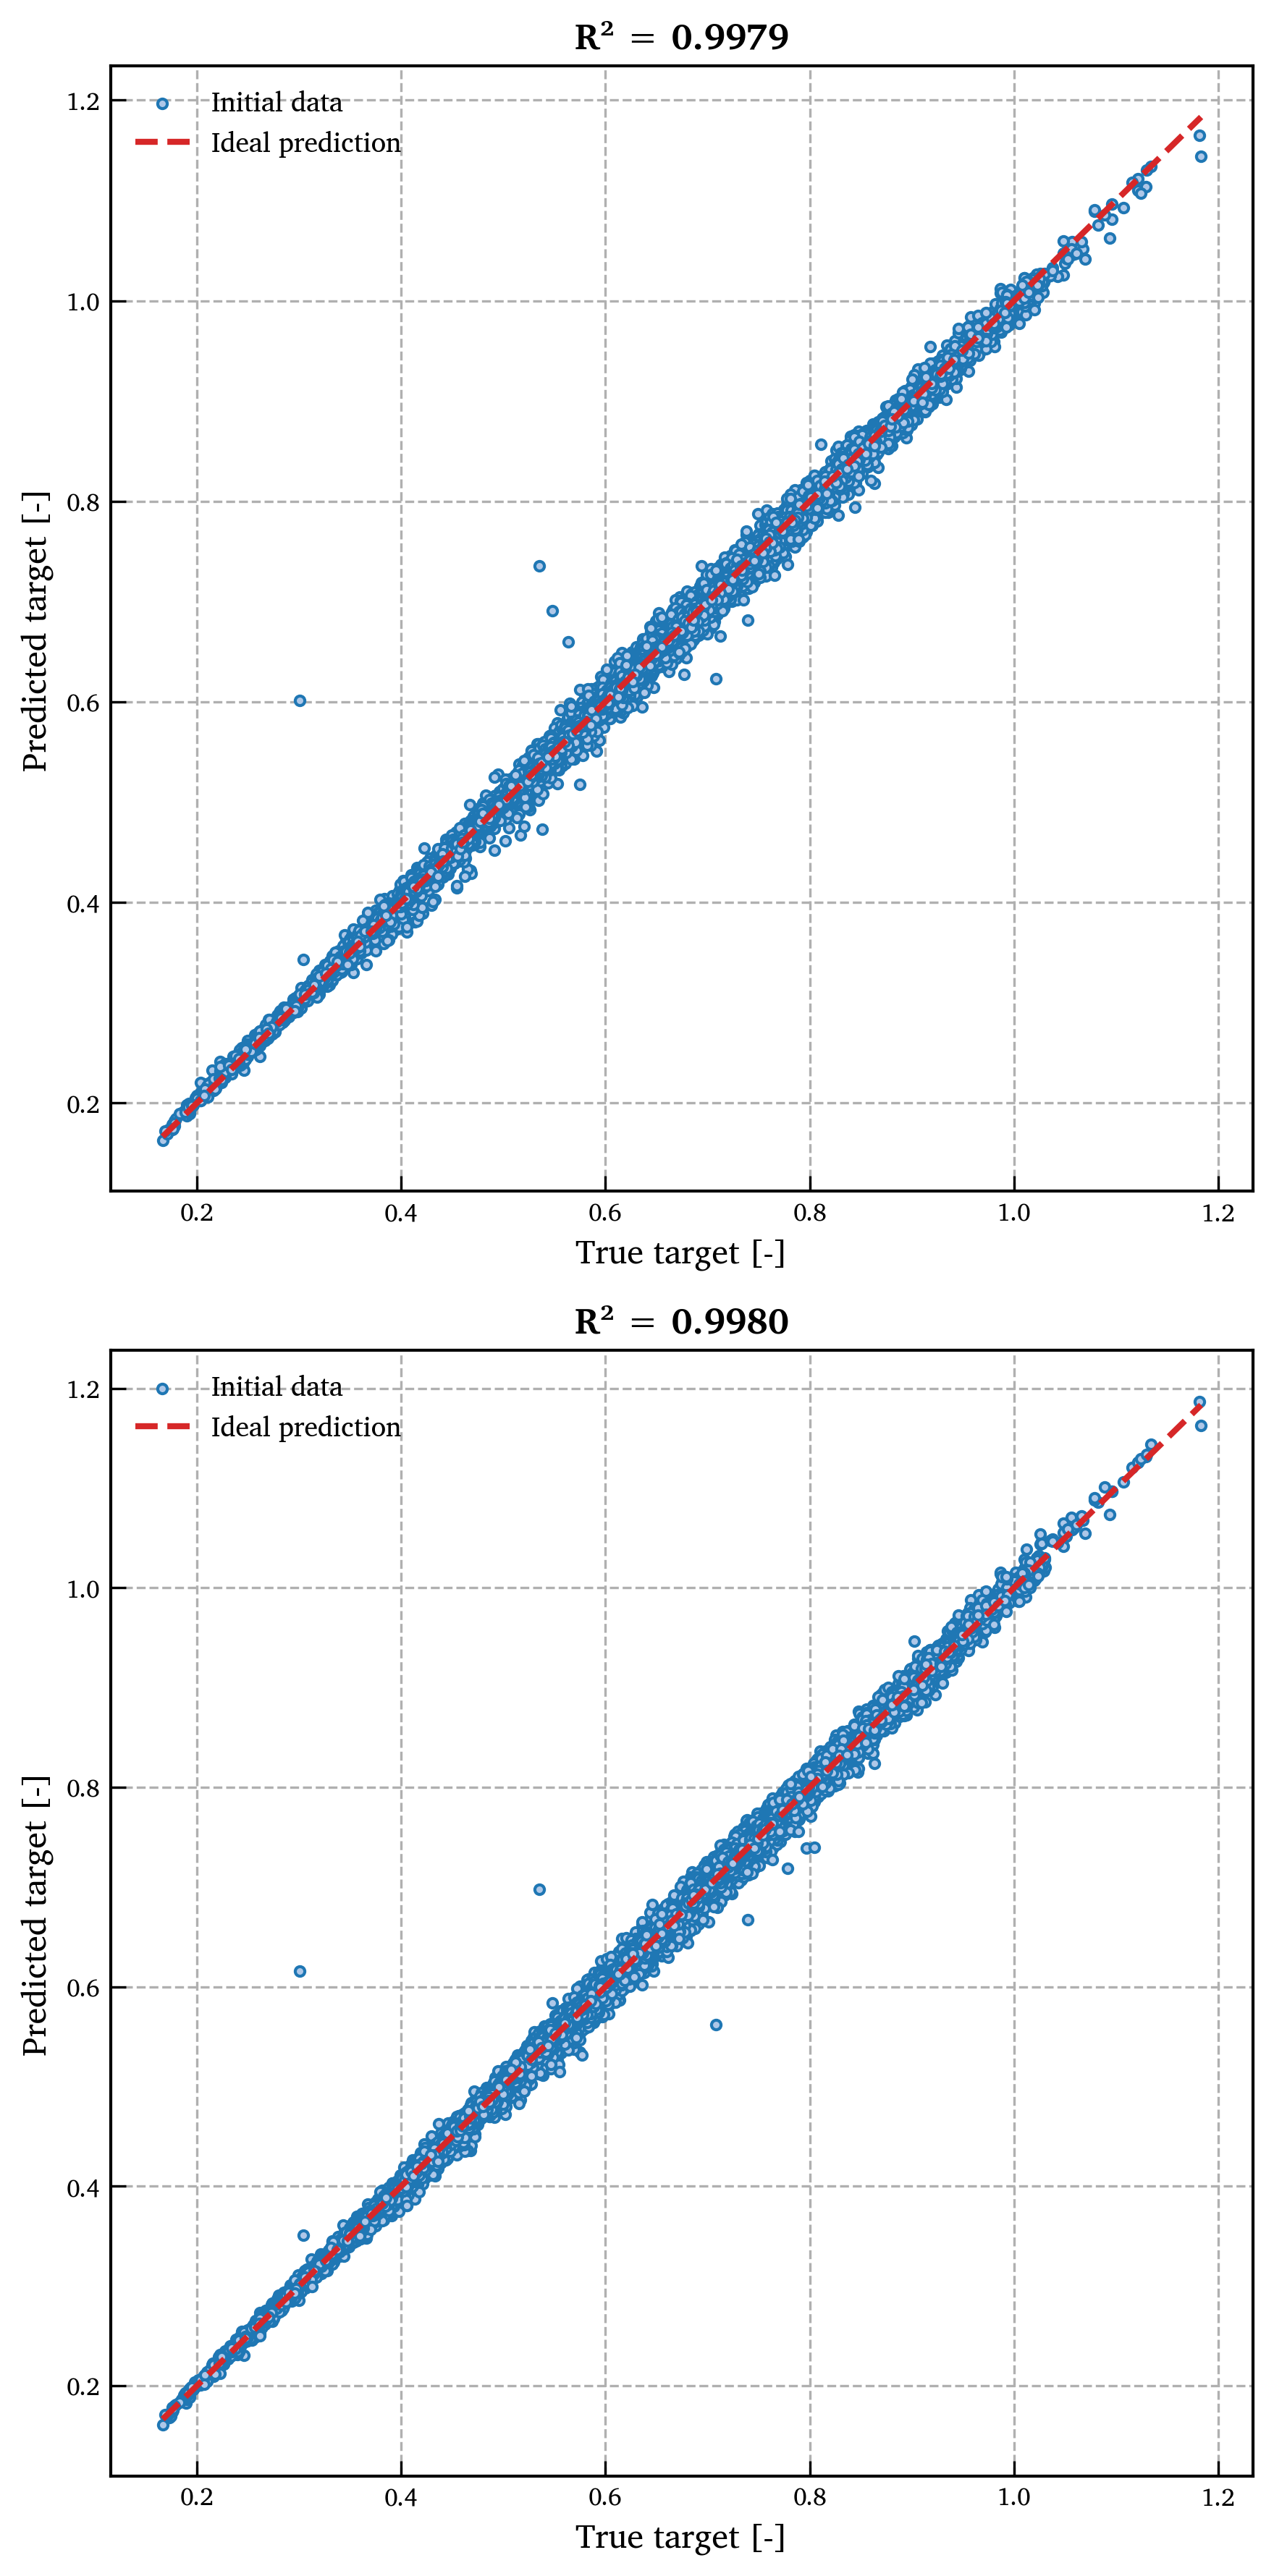

In [48]:
fig, axs = plt.subplots(2,1,figsize=(6, 12))

for i,y in enumerate([y_preds_test, y_preds_test_retrain]):
   R2 = 1 - np.sum((y - y_test)**2) / np.sum((y_test - np.mean(y_test))**2)

   ax = axs[i]

   ax.scatter(y_test, y,
               label='Initial data', 
               facecolor=plot_params.morecolors[1],
               edgecolor=plot_params.morecolors[0],
               s=10,
               zorder=2
               )

   ax.plot([y_test.min(), y_test.max()],
               [y_test.min(), y_test.max()], 
               color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal prediction',
               zorder=3)
   ax.set_title(f'R² = {R2:.4f}', fontsize=12, fontweight='bold')

   ax.grid(True, linestyle='--', zorder=0)
   ax.legend()

   ax.set_xlabel('True target [-]')
   ax.set_ylabel('Predicted target [-]')

plt.tight_layout()
plt.show()

#### Error Comparison

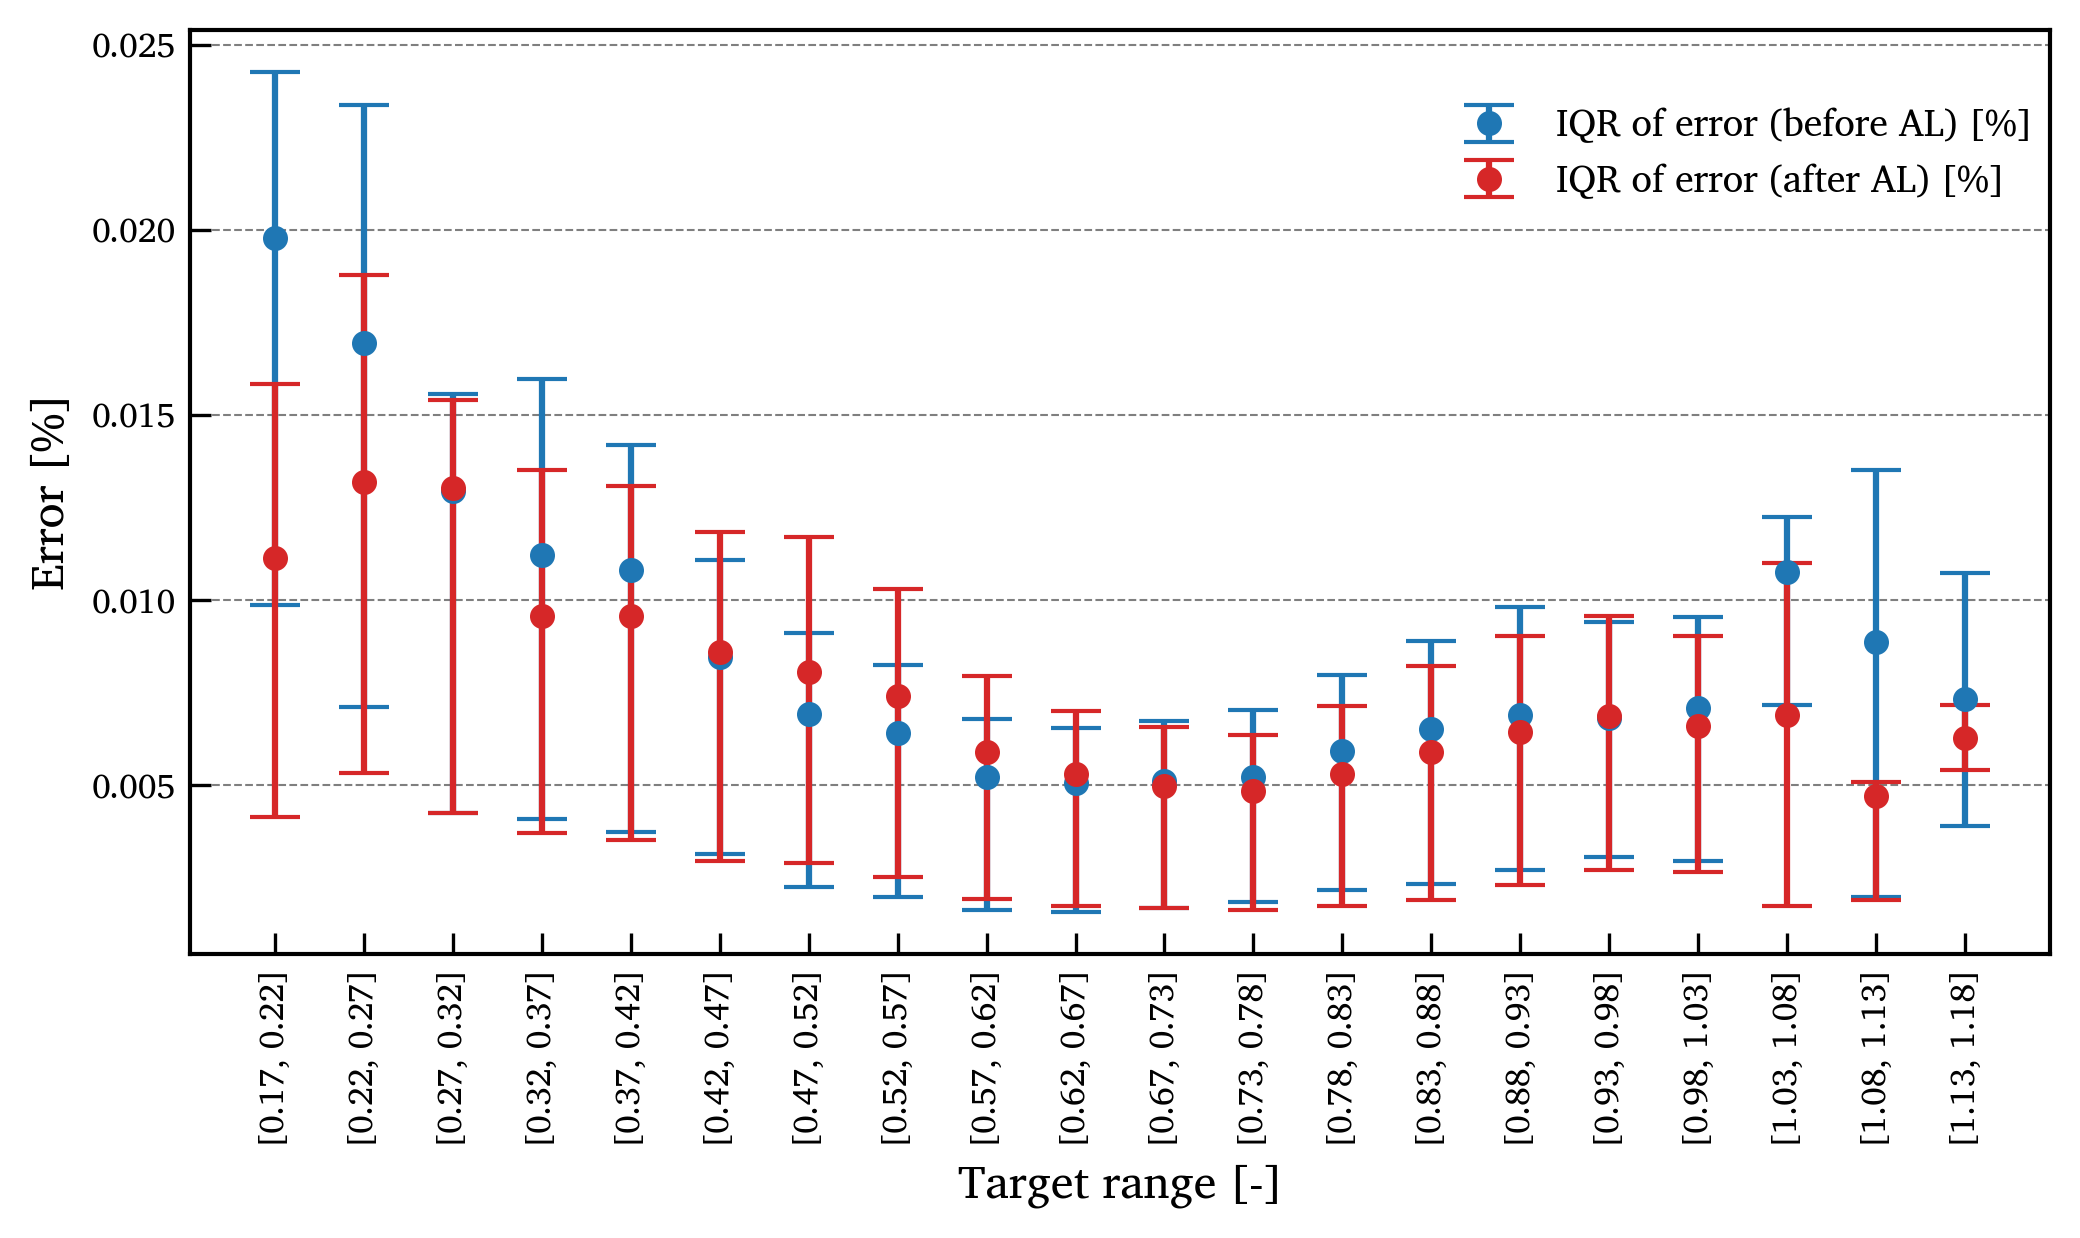

In [49]:
fig, ax1 = plt.subplots(figsize=(8,4))

counts, bins = np.histogram(y_test, bins=20)

for i in range(len(counts)):
    mask = np.logical_and(y_test >= bins[i], y_test < bins[i+1])

    error_bin = np.abs(error_test_before)[mask]
    error_bin_mean = error_bin.mean()

    error_AL_bin = np.abs(error_test_retrain)[mask]
    error_AL_bin_mean = error_AL_bin.mean()

    confidence = 50
    error_lower_val = np.percentile(error_bin, (100 - confidence) / 2)
    error_upper_val = np.percentile(error_bin, confidence + (100 - confidence) / 2)

    error_AL_lower_val = np.percentile(error_AL_bin, (100 - confidence) / 2)
    error_AL_upper_val = np.percentile(error_AL_bin, confidence + (100 - confidence) / 2)

    error_lower_bound = error_bin_mean - error_lower_val
    error_upper_bound = error_upper_val - error_bin_mean

    error_AL_lower_bound = error_AL_bin_mean - error_AL_lower_val
    error_AL_upper_bound = error_AL_upper_val - error_AL_bin_mean

    error_bounds = np.abs(np.array([[error_lower_bound], [error_upper_bound]]))
    error_AL_bounds = np.abs(np.array([[error_AL_lower_bound], [error_AL_upper_bound]]))

    if i==0:
        label1='IQR of error (before AL) [%]'
        label2 = 'IQR of error (after AL) [%]'
    else:
        label1=None
        label2=None
    ax1.errorbar(i, error_bin_mean, yerr=error_bounds, fmt='o', 
                 color=plot_params.colors[0], markersize=5, capsize=6,
                 label=label1)
    ax1.errorbar(i, error_AL_bin_mean, yerr=error_AL_bounds, fmt='o', 
                 color=plot_params.colors[3], markersize=5, capsize=6,
                 label=label2)

ax1.set_xlabel('Target range [-]')
ax1.set_ylabel('Error [%]')
ax1.set_xticks(np.arange(len(counts)))
ax1.set_xticklabels([f"[{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(counts))],rotation=90)
ax1.legend(loc=[0.67, 0.8])
plt.grid(True, axis='y', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.show()

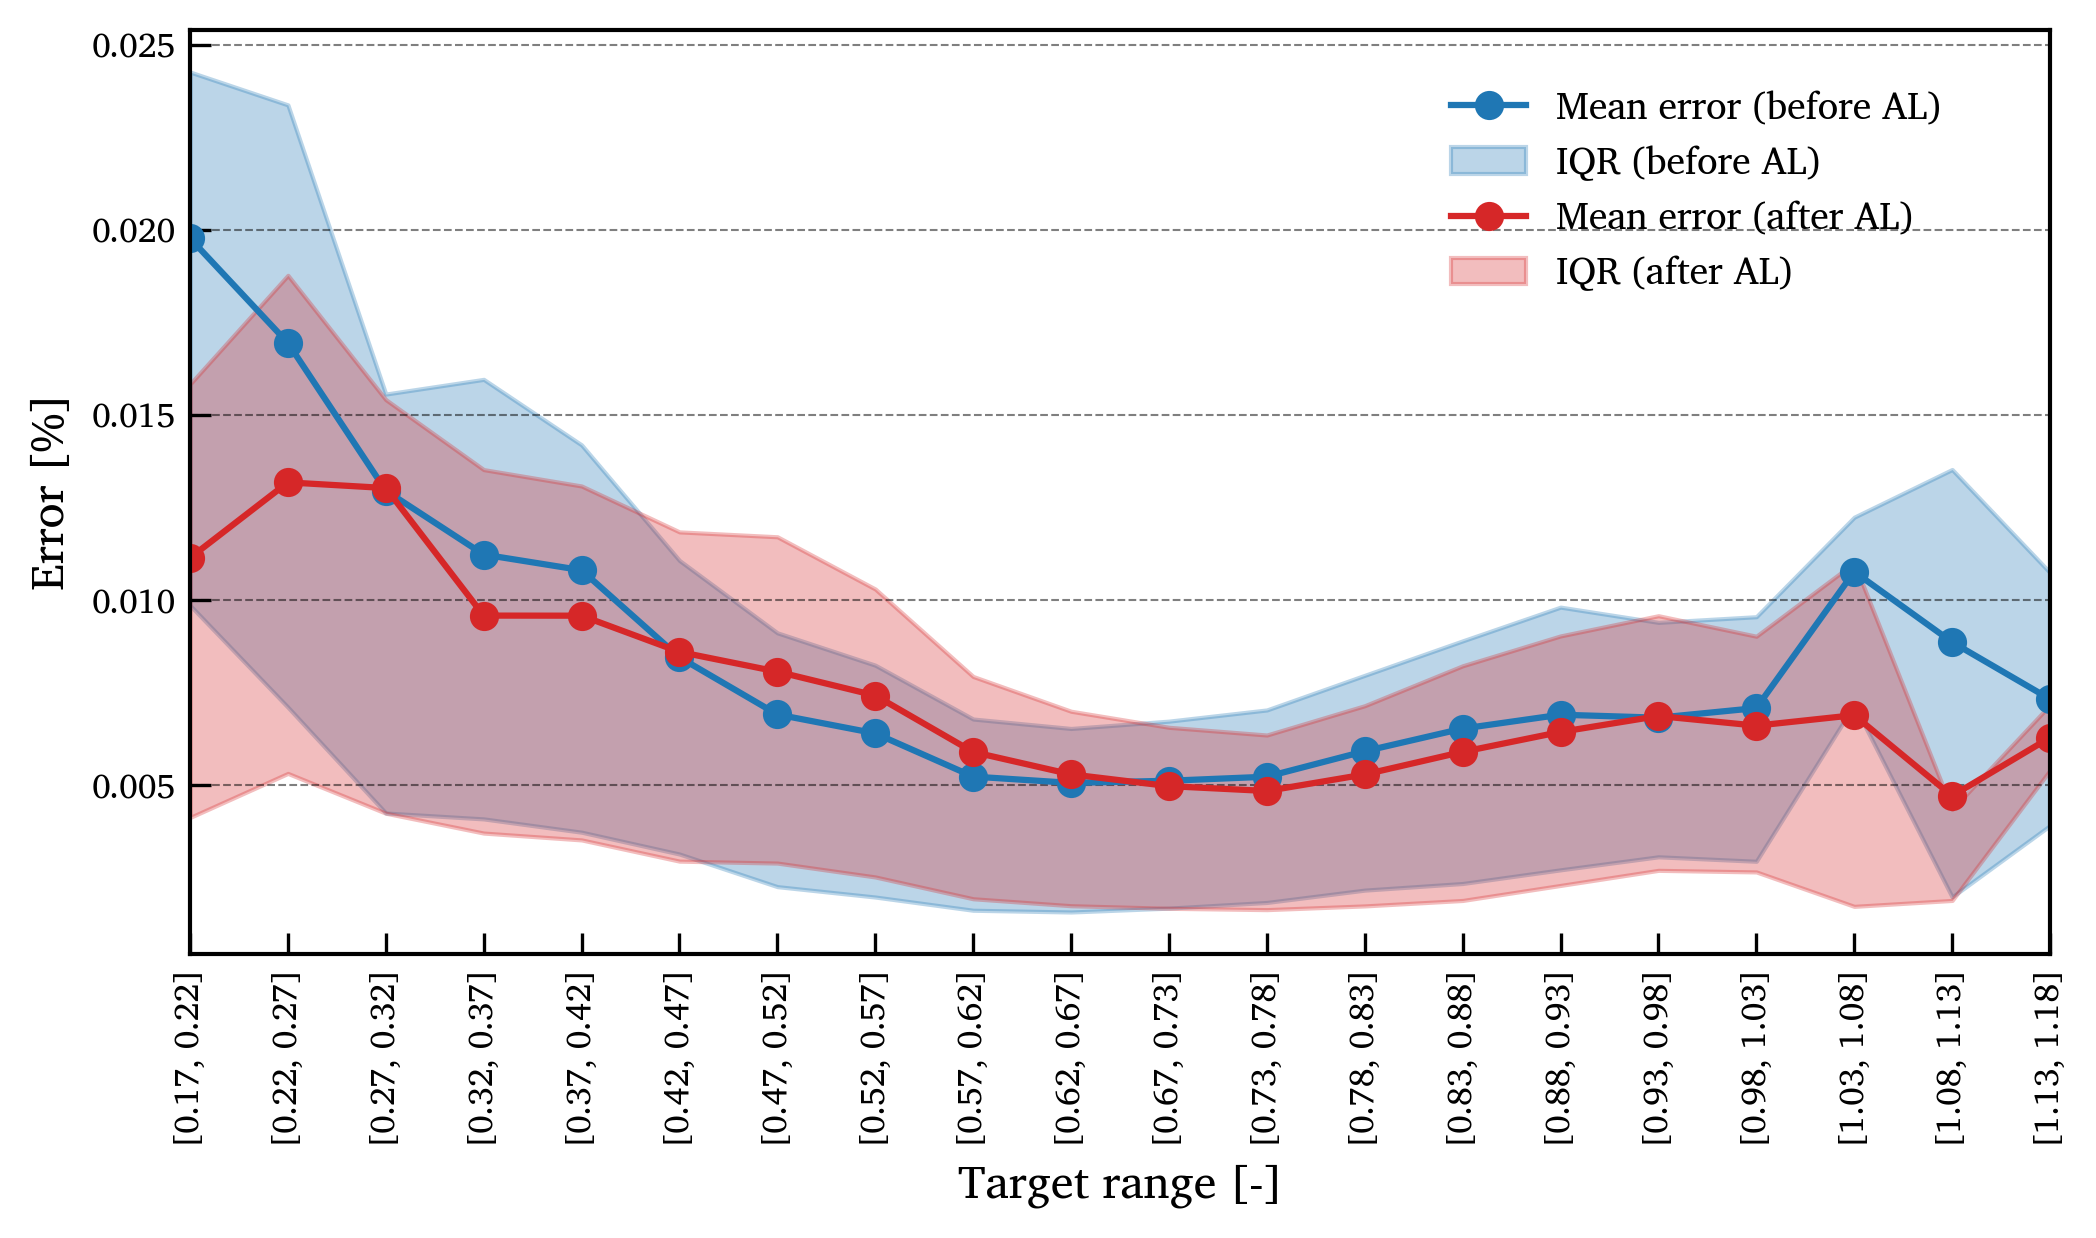

In [51]:
fig, ax1 = plt.subplots(figsize=(8,4))

counts, bins = np.histogram(y_test, bins=20)

x_vals = []
error_means = []
error_lowers = []
error_uppers = []

error_AL_means = []
error_AL_lowers = []
error_AL_uppers = []

for i in range(len(counts)):
    mask = np.logical_and(y_test >= bins[i], y_test < bins[i+1])

    error_bin = np.abs(error_test_before)[mask]
    error_bin_mean = error_bin.mean()

    error_AL_bin = np.abs(error_test_retrain)[mask]
    error_AL_bin_mean = error_AL_bin.mean()

    confidence = 50
    error_lower_val = np.percentile(error_bin, (100 - confidence) / 2)
    error_upper_val = np.percentile(error_bin, confidence + (100 - confidence) / 2)

    error_AL_lower_val = np.percentile(error_AL_bin, (100 - confidence) / 2)
    error_AL_upper_val = np.percentile(error_AL_bin, confidence + (100 - confidence) / 2)

    x_vals.append(i)

    error_means.append(error_bin_mean)
    error_lowers.append(error_lower_val)
    error_uppers.append(error_upper_val)

    error_AL_means.append(error_AL_bin_mean)
    error_AL_lowers.append(error_AL_lower_val)
    error_AL_uppers.append(error_AL_upper_val)

ax1.plot(x_vals, error_means, marker='o', color=plot_params.colors[0], label='Mean error (before AL)')
ax1.fill_between(x_vals, error_lowers, error_uppers, alpha=0.3, color=plot_params.colors[0], label='IQR (before AL)')

ax1.plot(x_vals, error_AL_means, marker='o', color=plot_params.colors[3], label='Mean error (after AL)')
ax1.fill_between(x_vals, error_AL_lowers, error_AL_uppers, alpha=0.3, color=plot_params.colors[3], label='IQR (after AL)')

ax1.set_xlabel('Target range [-]')
ax1.set_ylabel('Error [%]')
ax1.set_xticks(np.arange(len(counts)))
ax1.set_xticklabels([f"[{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(counts))], rotation=90)
ax1.legend(loc=[0.67, 0.7])
plt.xlim(min(x_vals), max(x_vals))
plt.grid(True, axis='y', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.show()


### Moment-Shear Interaction Curve predictions

In [ ]:
fixed_features = model.features.copy()
fixed_features.remove('M_contribution')
fixed_features.remove('V_contribution')

df_AL['group_id'] = df_AL[fixed_features].groupby(fixed_features).ngroup()
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

In [ ]:
profile = df_AL.loc[np.argsort(error_retrain)[-1]]

MRd_pred, VRd_pred, _ = model_retrained.get_MV_interaction_prediction(profile)
df_group = df_AL[df_AL['group_id'] == profile['group_id']].copy()

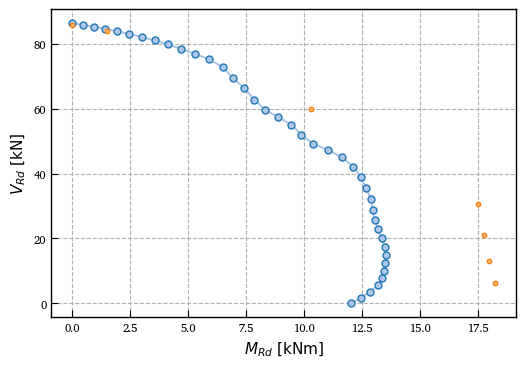

In [22]:
plt.plot(MRd_pred, VRd_pred,
         marker='o',
         color=plot_params.morecolors[1],
         markerfacecolor=plot_params.morecolors[1],
         markeredgecolor=plot_params.morecolors[0],
        markersize=5,
)

plt.scatter(df_group['M_Rd'], df_group['V_Rd'],
            facecolor=plot_params.morecolors[3],
            edgecolor=plot_params.morecolors[2],
            s=10,
            label='Added Samples',
            zorder=2)

plt.xlabel(plot_params.feature_labels['M_Rd'])
plt.ylabel(plot_params.feature_labels['V_Rd'])

plt.grid(True, linestyle='--', zorder=0)
            

## Identify computational validity 

### Numerical Identification

Use functions to calculate error metrics between predicted curves and datapoints.

This only works for added samples.

In [46]:
def calculate_error(curve, points):
    curve = np.asarray(curve, dtype=float)
    points = np.atleast_2d(np.asarray(points, dtype=float))

    diff = np.diff(curve, axis=0)
    lengths = np.sqrt((diff ** 2).sum(axis=1))
    unit_vectors = diff / lengths[:, np.newaxis]

    points = np.atleast_2d(points)
    # Extracts the starting point of each segment — these are the anchors for the line segments.
    start_points = curve[:-1]

    start_to_points = points[:, np.newaxis, :] - start_points
    # Scalar projection
    projections = np.einsum('ijk,jk->ij', start_to_points, unit_vectors)
    projections = np.clip(projections, 0, lengths)

    closest_points = start_points + unit_vectors * projections[..., np.newaxis]
    distances = np.sqrt(((closest_points - points[:, np.newaxis, :]) ** 2).sum(axis=2))
    
    min_distances = distances.min(axis=1)
    closest_indices = distances.argmin(axis=1)

    return min_distances, closest_indices

In [47]:
def filter_wrong_calculations(df_group,threshold_curve_distance=0.1, threshold_data_distance=0.1):
    n_before = len(df_full)
    group = np.array(df_group.index)
    mask_before = np.where(np.array(group) < n_before)[0]
    mask_added = np.where(np.array(group) >= n_before)[0]

    M_Rd_calc = df_group['M_Rd'].values
    V_Rd_calc = df_group['V_Rd'].values

    base_profile = df_group.iloc[0].copy()
    M_Rd_pred, V_Rd_pred, _ = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

    # Calculate distance to interaction curve
    interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
    added_resistances = np.array([M_Rd_calc[mask_added], V_Rd_calc[mask_added]]).T
    errors, closest_points = calculate_error(
        interaction_curve,
        added_resistances
    )

    vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)
    rel_deviation = errors / vector_lengths

    # Calculate distance to data points
    dist_to_data = np.zeros(len(mask_added))
    for i in range(len(mask_added)):
        point = added_resistances[i]
        points = np.array([M_Rd_calc[mask_before], V_Rd_calc[mask_before]]).T
        distances = np.linalg.norm(points - point, axis=1)
        closest_id = np.argmin(distances)
        dist_to_data[i] = np.min(distances) / np.linalg.norm(points[closest_id])

    valid = (rel_deviation > threshold_curve_distance) & (dist_to_data > threshold_data_distance)
    valid = ~valid
    valid = np.all(valid)

    return valid

In [48]:
n_before = len(df_full)
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        base_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()
        M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

        M_Rd_calc = df_group['M_Rd'].values
        V_Rd_calc = df_group['V_Rd'].values

        interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
        added_resistances = np.array([M_Rd_calc[mask_added], V_Rd_calc[mask_added]]).T
        errors, closest_points = calculate_error(
            interaction_curve,
            added_resistances
        )

        vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)

        rel_deviation = errors / vector_lengths
        df_AL.loc[np.array(group)[mask_added], 'rel_distance_to_curve'] = rel_deviation

        dist_to_data = np.zeros(len(mask_added))
        for i in range(len(mask_added)):
            point = added_resistances[i]
            points = np.array([M_Rd_calc[mask_before], V_Rd_calc[mask_before]]).T
            distances = np.linalg.norm(points - point, axis=1)
            closest_id = np.argmin(distances)
            dist_to_data[i] = np.min(distances) / np.linalg.norm(points[closest_id])

        df_AL.loc[np.array(group)[mask_added], 'rel_distance_to_data'] = dist_to_data

        valid = (rel_deviation > 0.1) & (dist_to_data > 0.1)
        valid = ~valid
        valid = np.all(valid)

        df_AL.loc[np.array(group)[mask_added], 'valid'] = valid

#### Visualize identified invalid profiles

In [ ]:
df_added = df_AL[~np.isnan(df_AL['rel_distance_to_curve'])].copy()

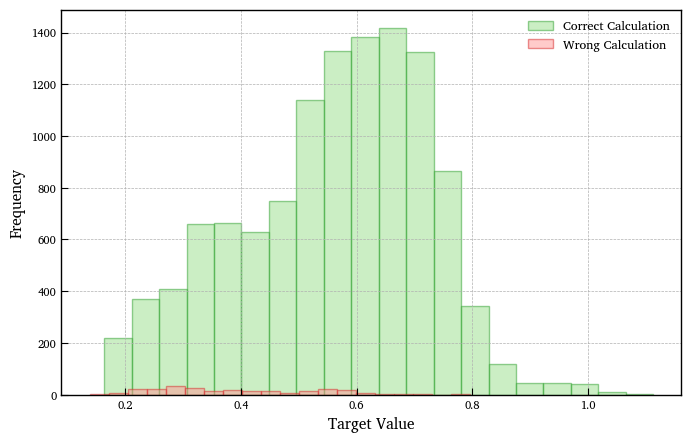

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.hist(df_added[df_added['valid']==True]['target'], bins =20, 
         edgecolor=plot_params.morecolors[4], 
         facecolor=plot_params.morecolors[5],
         alpha=0.5, label='Correct Calculation')

plt.hist(df_added[df_added['valid']==False]['target'], bins =20,
         edgecolor=plot_params.morecolors[6], 
         facecolor=plot_params.morecolors[7],
         alpha=0.5, label='Wrong Calculation')

plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [ ]:
print(f"Number of correct calculations: {len(df_added[df_added['valid']==True])}")
print(f"Number of wrong calculations: {len(df_added[df_added['valid']==False])}")

Number of correct calculations: 11757
Number of wrong calculations: 243


### Predict validity with Random Forest

This works for both the original data and the added data. Since the added data is already categorized with the numerical method, which is more precise, only the computational validity of the original data will be predicted.

Load Random Forest

In [54]:
with open(os.path.join(directory.root,r'Saved Variables\RF_calculation_validation.pkl'), 'rb') as f:
    forest = pickle.load(f)

Preprocess data for Random Forest

In [57]:
forest_features = model.features.copy()
forest_features.append('Cat_h')
forest_features.append('Cat_t_stiffc')
X = df_full[forest_features].select_dtypes(include='number').copy()

Get prediction on computational validity on original dataset. 

In [62]:
validity_pred = forest.predict(X)

Inser predictions into full dataset, containing original and added data.

In [80]:
df_AL.loc[ids_before, 'valid'] = validity_pred.astype(bool)

### Visualize results

In [82]:
valid_mask = df_AL['valid'] == True

In [ ]:
R2_valid = 1 - np.sum((y_preds_retrain[valid_mask] - y_truth[valid_mask])**2) / np.sum((y_truth[valid_mask] - np.mean(y_truth[valid_mask]))**2)

#### Filtering on full dataset (original + added)

In [122]:
print(f"From full dataset {len(df_full)} samples, {valid_mask.sum()} are valid ({valid_mask.sum()/len(df_full)*100:.2f}%)")
print(f"From added samples {len(df_added)} samples, {valid_mask[ids_added].sum()} are valid ({valid_mask[ids_added].sum()/len(df_added)*100:.2f}%)")

From full dataset 714385 samples, 657867 are valid (92.09%)
From added samples 12000 samples, 11757 are valid (97.97%)


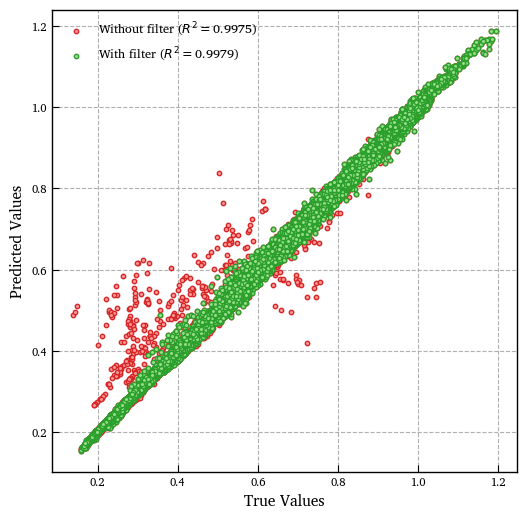

In [116]:
fig, ax = plt.subplots(figsize=(6,6))

plt.scatter(y_truth, y_preds_retrain,
            facecolor=plot_params.morecolors[7],
            edgecolor=plot_params.morecolors[6],
            s=10,
            label=f'Without filter ($R^2=${R2_retrain:.4f})',
            zorder=2)

plt.scatter(y_truth[valid_mask], y_preds_retrain[valid_mask],
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10,
            label=f'With filter ($R^2=${R2_valid:.4f})',
            zorder=2)

plt.legend()
plt.grid(True, linestyle='--', zorder=0)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

#### Filtering on original dataset

In [120]:
print(f"From original dataset {len(df_full)} samples, {np.sum(valid_mask[ids_before])} are valid ({np.sum(valid_mask[ids_before])/len(df_full)*100:.2f}%)")

From original dataset 714385 samples, 646110 are valid (90.44%)


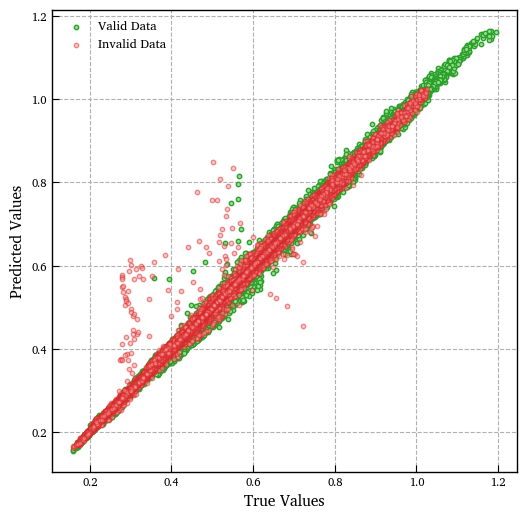

In [115]:
fig, ax = plt.subplots(figsize=(6, 6))

valid_mask_before = df_AL.loc[ids_before]['valid'] == True

plt.scatter(y_truth[ids_before][valid_mask_before], y_preds_before[ids_before][valid_mask_before],
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10,
            label=f'Valid Data',
            zorder=2)

plt.scatter(y_truth[ids_before][~valid_mask_before], y_preds_before[ids_before][~valid_mask_before],
            facecolor=plot_params.morecolors[7],
            edgecolor=plot_params.morecolors[6],
            s=10,
            label=f'Invalid Data',
            alpha=0.5,
            zorder=2)

plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True, linestyle='--', zorder=0)
         
plt.show()

## Global 